In [83]:
#make sure to download all of these packages
#python version that I used was 3.10, but most version of 3 should work
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [84]:
#gets the values that are outside of the IQR for a specific set features (classes = the label of df, and investigate = the features to check)
def outside_of_iqr(df : pd.DataFrame, investigate: str, classes: str) -> dict:

    #get all unique values of the class 
    values = df[classes].unique()
    dictionary = dict()

    for i in values:
        specific_quality = df.loc[df[classes] == i]

        #get the IQR of the feature that is a certain class
        q1 = specific_quality[investigate].quantile(0.25)
        q3 = specific_quality[investigate].quantile(0.75)

        #get temporary values of total ones that are outside of the range of a particular value
        temp = specific_quality[investigate].loc[(specific_quality[investigate] > q3) | (specific_quality[investigate] < q1)]
        dictionary.update({i: len(temp)})

    return dictionary


In [85]:
red_wine_data = pd.read_csv("data/winequality-red.csv",delimiter=";")
white_wine_data = pd.read_csv("data/winequality-white.csv",delimiter=";")

In [86]:
red_wine_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [87]:
red_wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Seems to be no missing data within all of the features at least for red

In [88]:
fig = go.Figure()
#getting the individual amounts of times the quality(lablels of the wine) appears in the dataset
quality_amounts_red = red_wine_data["quality"].groupby(red_wine_data["quality"]).count()
quality_amounts_white = white_wine_data["quality"].groupby(white_wine_data["quality"]).count()

#adding to a graph
fig.add_trace(go.Bar(x=quality_amounts_red.index,y=quality_amounts_red.values,name="reds"))
fig.add_trace(go.Bar(x=quality_amounts_white.index,y=quality_amounts_white.values,name="white"))

fig.show()

Overall the data set is imbalanced, so a accuracy measure will have to handle imbalanced. There is much more data in white, but at least it appears that they follow similar distribution

<AxesSubplot: >

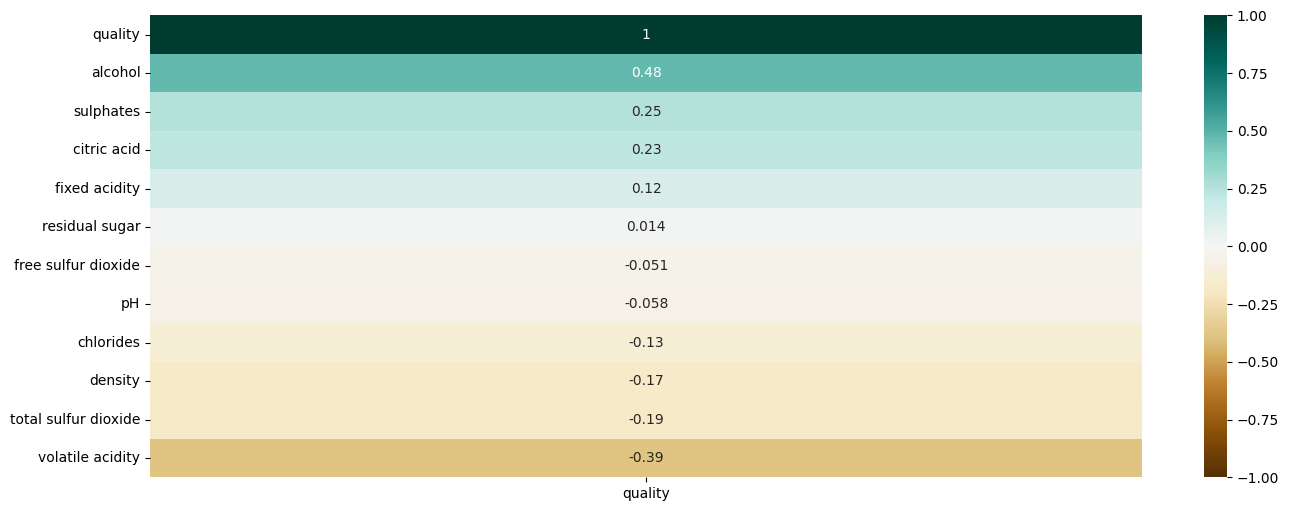

In [89]:
"""
vmin,vmax - the range of values for colormap(min-max)
cmap - sets the specific colormap to use
cetner - takes a float to centera color map
annot - if True sets the correlation values to appear
cbar - if False, the colorbar disapears

"""
plt.figure(figsize=(16,6))
sns.heatmap(red_wine_data.corr()[["quality"]].sort_values(by='quality',ascending=False), annot=True, vmin=-1,vmax=1,cmap='BrBG')

So, this diagram shows the relationship (correlation) between a feature and our label (quality). If the value is high(1) or low(-1) that entails that there is a strong correlation between the label and the quality. Unfortunantly we don't have many high ones of the bat, high ones being (volatile acididty and alcohol). However, this is raw data that we can try nead the data a bit more (binning and such).

<AxesSubplot: >

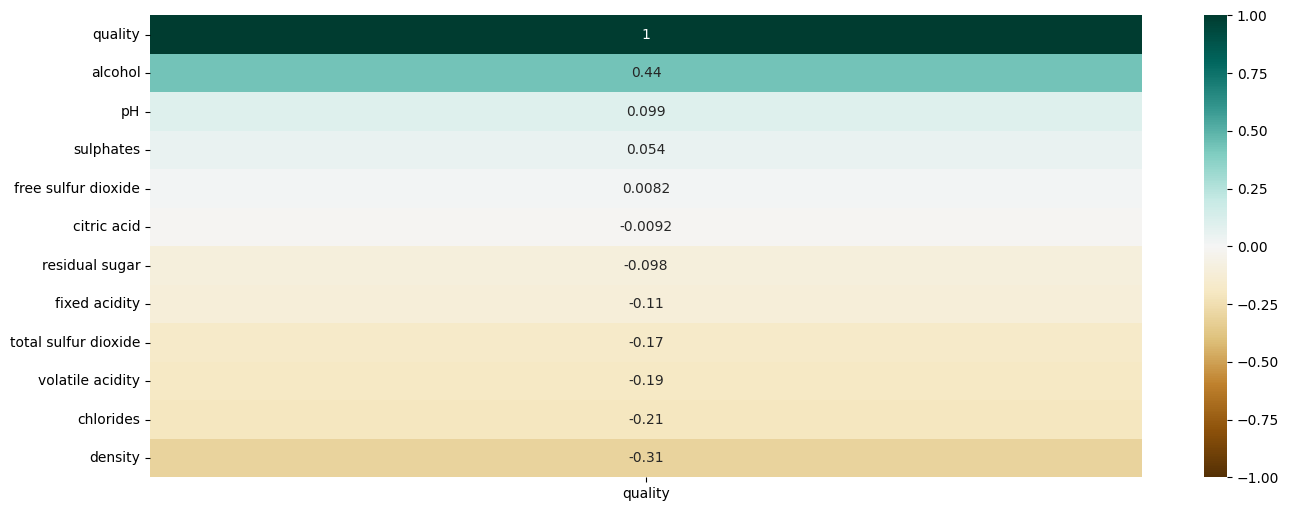

In [90]:
plt.figure(figsize=(16,6))
sns.heatmap(white_wine_data.corr()[["quality"]].sort_values(by='quality',ascending=False), annot=True, vmin=-1,vmax=1,cmap='BrBG')

In white wines it appears that the lowest correlations (between -0.1 and 0.1) are the same (free sulfur dioxide,residual sugar,ph), so it seems fair to drop these from consideration; however it might be worthwhile to check later if there are some values that are throwing off others. For inital EDA these will be dropped. 

Citric acid and suplates appeared to show strong correlation in red but not white. Will need to combine data sets and do EDA on all at the same time

Overall, it seems that red wine has much stonger correlation between specific attributes; therefore we are going to use the red wine for our models. This comes with an unfortunate tradeoff, as the white wine dataset has more data overall, which might pose issues with our neural network attempt.

In [92]:
red_wine_data = red_wine_data.drop(["free sulfur dioxide","residual sugar" ,"pH"],axis=1)

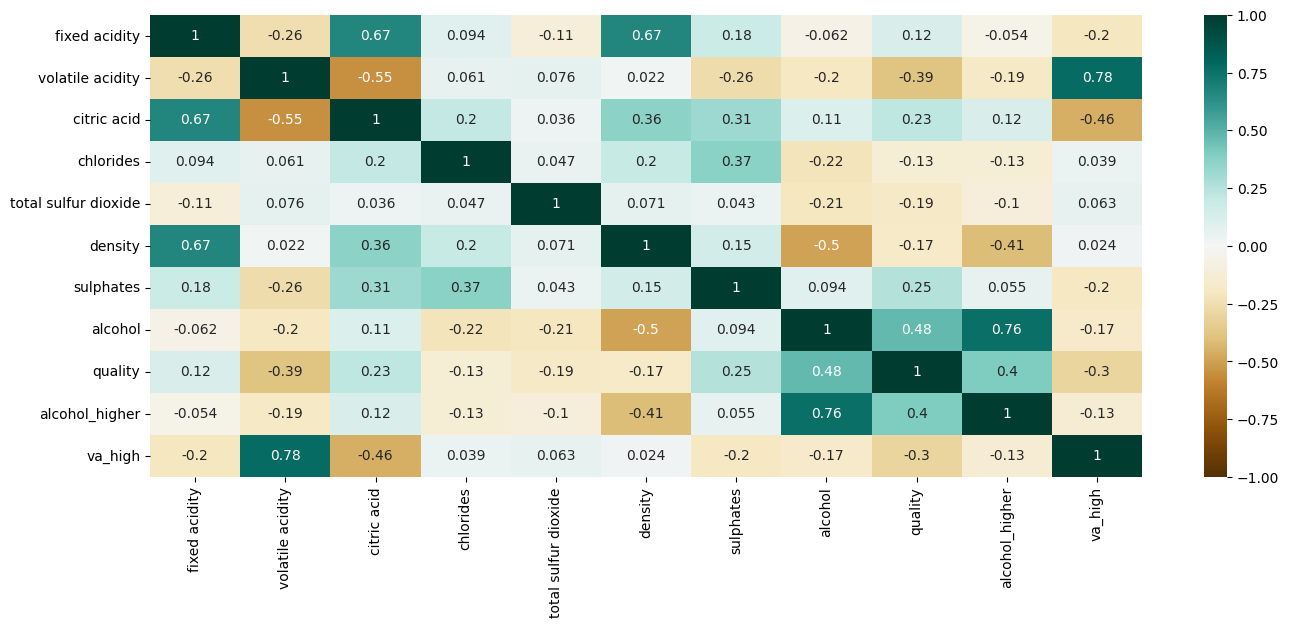

In [125]:
"""
    Overall shows the direct or indirect correlation between features of a dataset. For anaylsis like this, only the direct linear relationship
    of two features. Measuring anything beyond the relationship of two is not possible in this method. 
"""
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(red_wine_data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

---
Attribute: Alcohol

In [94]:
#Alcohol stuff
from plotly.subplots import make_subplots

fig = make_subplots(rows=1,cols=2)

#histogram for red
fig.append_trace(go.Histogram(
    x=red_wine_data["alcohol"],
    name="red hist"), row=1,col=1)

#boxplot for red
fig.append_trace(go.Box(
    x=red_wine_data["alcohol"],
    name="red box"
),row=1,col=2)

#histogram for white
fig.update_layout(height=600, width=1200, title_text="Alochol data")
fig.show()

Appears to be a bit skewed but overal, not a huge amount of problems.

In [95]:
px.box(red_wine_data,x="quality",y="alcohol",title="Red Wine")

Can see a bit of a trend here, as the value of alchol increases so does the actual value of alchol, and it appears that there is a considerable jump from 5 to 6

In [96]:
mean_red = red_wine_data.loc[(red_wine_data["quality"] >= 7)]["alcohol"].mean()
greater_than_mean = red_wine_data.loc[red_wine_data["quality"] < 7]["alcohol"].values >= mean_red

less_than_mean = red_wine_data.loc[(red_wine_data["quality"] >= 7)]["alcohol"].values < mean_red
sum(less_than_mean), sum(greater_than_mean),len(red_wine_data)

(107, 140, 1599)

It seems that we might want to split the classes into just two binary variables, overall it seems that our bet will to have (1-5) and (6-10)

In [97]:
red_wine_data["alcohol_higher"] = 0
red_wine_data.loc[red_wine_data["alcohol"] >= mean_red, "alcohol_higher"] =1 

---
Attribute: density

In [98]:
#density seems to be very very small differences, I doubt this will be any help but we can check
red_wine_data["density"].describe()

count    1599.000000
mean        0.996747
std         0.001887
min         0.990070
25%         0.995600
50%         0.996750
75%         0.997835
max         1.003690
Name: density, dtype: float64

In [99]:
px.histogram(red_wine_data,x="density")

In [100]:
px.box(red_wine_data,x="quality",y="density",title="Red Wine")

almost a perfect distribution for normal

--- 
Attribute: vaolatile acidity

In [101]:
red_wine_data["volatile acidity"].describe()

count    1599.000000
mean        0.527821
std         0.179060
min         0.120000
25%         0.390000
50%         0.520000
75%         0.640000
max         1.580000
Name: volatile acidity, dtype: float64

There is pretty good standard deviation, so plausible that we might be able to use this data pretty well for banding.

In [102]:
fig = make_subplots(rows=1,cols=2)

#histogram for red
fig.append_trace(go.Histogram(
    x=red_wine_data["volatile acidity"],
    name="red hist"), row=1,col=1)

#boxplot for red
fig.append_trace(go.Box(
    x=red_wine_data["volatile acidity"],
    name="red box"
),row=1,col=2)


fig.update_layout(height=600, width=1200, title_text="Volatile Acidity")
fig.show()

Bit skewed but more normal if anything

In [103]:
px.box(red_wine_data,x="quality",y="volatile acidity",title="Red Wine")

In [104]:
means_of_red = red_wine_data.groupby(red_wine_data["quality"]).mean()
medians_of_red = red_wine_data.groupby(red_wine_data["quality"]).median()

In [105]:
means_of_red["volatile acidity"],medians_of_red["volatile acidity"]

(quality
 3    0.884500
 4    0.693962
 5    0.577041
 6    0.497484
 7    0.403920
 8    0.423333
 Name: volatile acidity, dtype: float64,
 quality
 3    0.845
 4    0.670
 5    0.580
 6    0.490
 7    0.370
 8    0.370
 Name: volatile acidity, dtype: float64)

In [106]:
#geting tuples that have a quality that is greater than five
greater_than_five = red_wine_data.loc[red_wine_data["quality"] > 5]
greater_than_five["volatile acidity"].describe()

count    855.000000
mean       0.474146
std        0.161999
min        0.120000
25%        0.350000
50%        0.460000
75%        0.580000
max        1.040000
Name: volatile acidity, dtype: float64

In [107]:
#getting the avlues that are greater than five, and have less than 0.6 volatile acidity
high_quality_less = greater_than_five.loc[greater_than_five["volatile acidity"] < 0.6]
#getting the values that are greater than five, and have more than 0.6 volatile acidity
high_quality_more = greater_than_five.loc[greater_than_five["volatile acidity"] >= 0.6]
print("Amount that fit the band " + str(len(high_quality_less)))
print("Amount that do not fit the band " + str(len(high_quality_more)))

Amount that fit the band 664
Amount that do not fit the band 191


In [108]:

less_than_five = red_wine_data[red_wine_data["quality"] < 5]
less_than_five["volatile acidity"].describe()

count    63.000000
mean      0.724206
std       0.247970
min       0.230000
25%       0.565000
50%       0.680000
75%       0.882500
max       1.580000
Name: volatile acidity, dtype: float64

In [109]:
high_quality_less = less_than_five.loc[less_than_five["volatile acidity"] <= 0.6]
high_quality_more = less_than_five.loc[less_than_five["volatile acidity"] > 0.6]
print("Amount that fit the band " + str(len(high_quality_more)))
print("Amount that do not fit the band " + str(len(high_quality_less)))

Amount that fit the band 42
Amount that do not fit the band 21


In [110]:
#creating a binary feature
red_wine_data["va_high"] = 0
red_wine_data.loc[red_wine_data["volatile acidity"] >= 0.6, "va_high"] = 1
red_wine_data

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality,alcohol_higher,va_high
0,7.4,0.700,0.00,0.076,34.0,0.99780,0.56,9.4,5,0,1
1,7.8,0.880,0.00,0.098,67.0,0.99680,0.68,9.8,5,0,1
2,7.8,0.760,0.04,0.092,54.0,0.99700,0.65,9.8,5,0,1
3,11.2,0.280,0.56,0.075,60.0,0.99800,0.58,9.8,6,0,0
4,7.4,0.700,0.00,0.076,34.0,0.99780,0.56,9.4,5,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,0.090,44.0,0.99490,0.58,10.5,5,0,1
1595,5.9,0.550,0.10,0.062,51.0,0.99512,0.76,11.2,6,0,0
1596,6.3,0.510,0.13,0.076,40.0,0.99574,0.75,11.0,6,0,0
1597,5.9,0.645,0.12,0.075,44.0,0.99547,0.71,10.2,5,0,1


This also might cause overfitting due to the correlation with volatile acididty in general. However, it should at least be helpful in determining red wines better. Check confusion matrix at the end and run models with and without the values

---
Attribute : Total sulfur dioxide

In [111]:
red_wine_data["total sulfur dioxide"].describe(), white_wine_data["total sulfur dioxide"].describe()

(count    1599.000000
 mean       46.467792
 std        32.895324
 min         6.000000
 25%        22.000000
 50%        38.000000
 75%        62.000000
 max       289.000000
 Name: total sulfur dioxide, dtype: float64,
 count    4898.000000
 mean      138.360657
 std        42.498065
 min         9.000000
 25%       108.000000
 50%       134.000000
 75%       167.000000
 max       440.000000
 Name: total sulfur dioxide, dtype: float64)

In [112]:
px.histogram(red_wine_data,x="total sulfur dioxide")

In [113]:
px.box(red_wine_data,x="quality",y="total sulfur dioxide",title="Red Wine TSD")

This data is highly skewed and it might be worthwhile to try and to a transformation to smooth it out. Either smooth or turn into a standard scaler.

---
Attribute: citiric acid 

In [114]:
red_wine_data["citric acid"].describe()

count    1599.000000
mean        0.270976
std         0.194801
min         0.000000
25%         0.090000
50%         0.260000
75%         0.420000
max         1.000000
Name: citric acid, dtype: float64

In [115]:
px.histogram(red_wine_data,x="citric acid")

In [116]:
px.box(red_wine_data,x="quality",y="citric acid",title="Red Wine Citric acid")

In [117]:
outside_of_iqr(red_wine_data, "citric acid", "quality")

{5: 327, 6: 309, 7: 96, 4: 25, 8: 9, 3: 6}

Even though it might look like there could be not real outliers, there is still a great deal of variance within the upper and lower, fence out outside of the IQR

---
Main winners: ones in parenthesis are simplified attributes. Might be helpful in certain algorithms, we can try to use both main attribute and other attribute, but should be warry of overfitting

Positive - Alcohol (alcohol_higher), sulphates, citric acid
    
Negative - Volatile acidity (va_high), Total sulfur dioxide, density


Possible drops -- fixed acidity, and chlorides

In [119]:
red_wine_data["graphing qualities"] = ""
red_wine_data.loc[red_wine_data["quality"] > 6, "graphing qualities"] = "7-8"
red_wine_data.loc[red_wine_data["quality"] < 5, "graphing qualities"] = "3-4"
red_wine_data.loc[(red_wine_data["quality"] < 7) & (red_wine_data["quality"] > 4), "graphing qualities"] = "5-6"

---
Cholrides/Sulphates : sulphates have a good correlation, but cholorides do not. However, both have a decent correlation together. It might be worth the time to remove chlorides to reduce confusion in the model, or integrate it somehow but lose unimportant information.

In [120]:
#Alcohol stuff
fig = make_subplots(rows=2,cols=3)

#histogram for red
fig.append_trace(go.Histogram(
    x=red_wine_data["chlorides"],
    nbinsx=10,
    name="chloride hist"
), row=1,col=1)

#boxplot for red
fig.append_trace(go.Box(
    x=red_wine_data["chlorides"],
    name="chloride box"
),row=1,col=2)

fig.append_trace(go.Box(
    x=red_wine_data["quality"],
    y=red_wine_data["chlorides"],
    name="quality chlorides"
), row=1,col=3)

fig.append_trace(go.Histogram(
    x=red_wine_data["sulphates"],
    nbinsx=10,
    name="sulphate hist"
), row=2,col=1)

#boxplot for red
fig.append_trace(go.Box(
    x=red_wine_data["sulphates"],
    name="sulphate box"
),row=2,col=2)

fig.append_trace(go.Box(
    x=red_wine_data["quality"],
    y=red_wine_data["sulphates"],
    name="quality sulphates"
), row=2,col=3)

fig.update_layout(height=600, width=1250, title_text="Sulphates/Chlorides")
fig.show()

In [121]:
fig = px.scatter(red_wine_data, x="chlorides", y="sulphates", color="graphing qualities", hover_data=['sulphates'])
fig.show()

Both have very similar distributions, and the correlation just appears to arise that they cluster around a similar area. There is no way to actually discern where certain values would be in their combination, so I would wager we could just drop chlorides.

---
fixed acidity/density/citric acid

In [122]:
#Alcohol stuff
fig = make_subplots(rows=3,cols=3)

fig.append_trace(go.Histogram(
    x=red_wine_data["fixed acidity"],
    name="fixed acidity hist"
), row=1,col=1)

fig.append_trace(go.Box(
    x=red_wine_data["fixed acidity"],
    name="fixed acidity box"
),row=1,col=2)

fig.append_trace(go.Box(
    x=red_wine_data["quality"],
    y=red_wine_data["fixed acidity"],
    name="quality fixed acidity"
), row=1,col=3)

fig.append_trace(go.Histogram(
    x=red_wine_data["density"],
    name="density hist"
), row=2,col=1)

fig.append_trace(go.Box(
    x=red_wine_data["density"],
    name="density box"
),row=2,col=2)

fig.append_trace(go.Box(
    x=red_wine_data["quality"],
    y=red_wine_data["density"],
    name="quality density"
), row=2,col=3)

fig.append_trace(go.Histogram(
    x=red_wine_data["citric acid"],
    name="citric acid hist"
), row=3,col=1)

fig.append_trace(go.Box(
    x=red_wine_data["citric acid"],
    name="citric acid box"
),row=3,col=2)

fig.append_trace(go.Box(
    x=red_wine_data["quality"],
    y=red_wine_data["citric acid"],
    name="quality citric acid"
), row=3,col=3)


fig.update_layout(height=600, width=1250, title_text="Sulphates/Chlorides")
fig.show()

Fixed acidity, and density have a similar distribution if you do not consider the scaling of the values. On the other hand, citric acid seems to be much different overall.

In [123]:
red_wine_data = red_wine_data.drop(["graphing qualities"],axis=1)
red_train, red_test = train_test_split(red_wine_data,test_size=0.2,stratify=red_wine_data["quality"])

When it comes to the analysis of individual features, there does not seem anything more we can do except scale and remove outliers when needed.For KNN we should scale, DT won't need much, and NN will need scaling of some kind. However, there is a chance that there are interactions between features in more complex way. If we had more time we could try and figure out, but I have no experience beyond direct correlation. Therefore, we can leave that to another day. 

In [124]:
red_train.to_csv("data/red_wine_train.csv")
red_test.to_csv("data/red_wine_test.csv")